In [1]:
from IPython.display import HTML
HTML('''<script>
    code_show=true; 
    function code_toggle() {
        if (code_show){
         $('div.input').hide();
         } else {
         $('div.input').show();
         }
         code_show = !code_show
    } 
    $( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Primer on Three of the Most Popular Machine Learning Classifiers

Author: Greg Strabel
    
This notebook is a primer on three of the most popular machine learning algorithms for classification problems. I first generate a dataset suitable for classification using the dataGenerator module posted on my GitHub page. This dataset is built to be similar to those encountered in the insurance industry with a mix of categorical and continuous variables. For each of the machine learning algorithms, I give a brief introduction and then fit the model to the data.

In [2]:
# import Python packages, modules and functions

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataGeneratorClass import dataGenerator, plotData # this module is on my GitHub page
from sklearn import preprocessing
import warnings
from importlib import reload
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth', -1)
def pretty_df(df, n = 10):
    return df.head(n).style.set_properties(**{'text-align': 'center',
                            'white-space': 'nowrap'})

In [3]:
# Generate data

catg_lvls = [5, 8, 3] # 3 categorical variables with corresponding # of levels
n_cat = len(catg_lvls)
n_beta = 2 # number of beta variables
n_uniform = 1 # of uniform variables
n = n_cat + n_beta + n_uniform
N = 120000 # number of observations
responseMean = 0.5 # Bernoulli response mean
p_width = 1
np.random.seed(123)
trainPercent = 2./3 # fraction of data for training
testPercent = 1./6
Ntrain = int(N * trainPercent);
Ntest = int(N * testPercent)


x = dataGenerator(catg_lvls = catg_lvls, n_beta = n_beta, n_uniform = n_uniform)
df1, df2 = x.generate(1000)
f = x.genSigmoidTransform(df2, loc = responseMean, width = p_width)
df1, df2 = x.generate_more(N)
df = pd.concat([df1,pd.DataFrame(x.genBernoulliVariates(df2,f),columns=['Response'])],axis=1)

train, test, validate = df[:Ntrain], df[Ntrain:Ntrain+Ntest], df[Ntrain+Ntest:]

X_train = pd.get_dummies(train[x.featureNames], prefix_sep = ' Level : ')
Y_train = train.Response
scaler = preprocessing.StandardScaler().fit(X_train.loc[:,x.cont_cols].values)
X_train_scaled = X_train.copy()
X_train_scaled.loc[:,x.cont_cols] = (scaler.transform(X_train.loc[:,
            x.cont_cols].values))
X_test = pd.get_dummies(test[x.featureNames], prefix_sep=' Level : ')
X_test_scaled = X_test.copy()
X_test_scaled.loc[:,x.cont_cols] = (scaler.transform(X_test.loc[:,
            x.cont_cols].values))
Y_test = test.Response
X_validate = pd.get_dummies(validate[x.featureNames], prefix_sep=' Level : ')
X_validate_scaled = X_validate.copy()
X_validate_scaled.loc[:,x.cont_cols] = (scaler.transform(X_validate.loc[:,
            x.cont_cols].values))
Y_validate = validate.Response

To get a sense for the data, I plot histograms for each of the features (gray bars) along with the response means for the given bucket (orange lines). The first three features are unordered categorical variables, while the final three features are continuous. It is important to emphasize that, although I use numbers to label the levels of the categorical variables, these variables are not numeric and have no natural ordering. As an example, imagine that U.S. states are a categorical variable and that rather than use the states' names or abbreviations as the level labels, we assign state codes 1 through 50. We would not treat the order of these numbers as meaningful and would certainly not attempt to fit a line or curve to this variable directly.

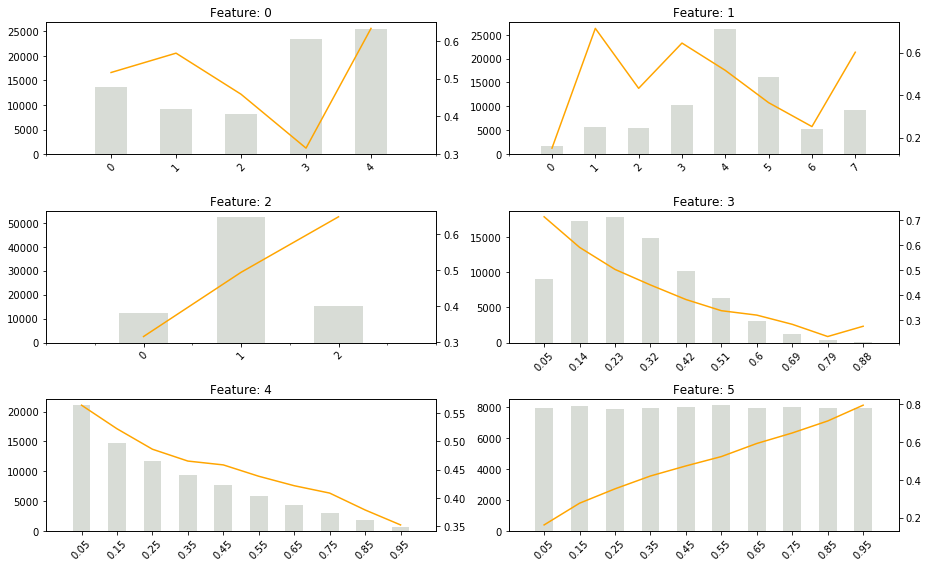

In [4]:
plotData(train, response = 'Response')

Before proceeding, two observations are in order.

First, in machine learning and statistical analysis more generally, it is a best practice to partition one's data into 2 to 3 subsets: a training dataset, a test dataset and a validation dataset. The training dataset is used to make preprocessing decisions (grouping/binning, scaling and centering, applying transformations such as natural logarithms, etc.) as well as fitting the model directly. If the model being used requires tuning (for instance, selecting hyperparameters) the test set is used for making these decisions. Finally, the validation dataset is used as a final check of the predictive power of the model as well as objective comparisons of different models. Of course, these are not hard and fast rules and, depending on the situation, a modified approach may be required and justifiable.

Second, most machine learning algorithms cannot use unordered categorical variables directly; they expect all variables to be numeric. As a result, the most common method of dealing with categorical variables in machine learning is to one-hot-encode the variables. One-hot-encoding is the process of creating one new variable for each level of a categorical variable which is a 1-0 indicator for whether the categorical variable for a given observation takes on the given level.

For instance, observations of 'Feature: 0' will appear as:

In [7]:
pretty_df(train.loc[:,['Feature: 0']])

,Feature: 0
0,1
1,4
2,3
3,4
4,4
5,3
6,0
7,3
8,1
9,4


However, the machine learning algorithms below will be fed a one-hot-encoded version of 'Feature: 0':

In [8]:
pretty_df(X_train[[i for i in X_train.columns.tolist() if i.find('Feature: 0') != -1]])

,Feature: 0 Level : 0,Feature: 0 Level : 1,Feature: 0 Level : 2,Feature: 0 Level : 3,Feature: 0 Level : 4
0,0,1,0,0,0
1,0,0,0,0,1
2,0,0,0,1,0
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,1,0
6,1,0,0,0,0
7,0,0,0,1,0
8,0,1,0,0,0
9,0,0,0,0,1


### Penalized Logistic Regression

The first machine learning classifier we will consider is classic logistic regression. Logistic regression models are one of the most popular classifiers for 2-class problems (i.e. classification problems having 2 classes; logistic regression models can be extended to 3+ class problems). As such, logistic regression is a good benchmark for comparison to other machine learning classifiers.

With two classes, labeled 0 and 1, logistic regression assumes that the probability of an observation with features $X$ being of class 1 is $$\frac{1}{1 + e^{-\beta \cdot X}}$$

Logistic regression solves for the value of $\beta$ that minimizes the empirical loss function: $$\sum\limits_{i=1}^N [(1-y_i) \cdot \beta \cdot x_i + \ln(1 + e^{-\beta \cdot x_i})]$$

To prevent overfitting the model, a penalization term is often added to the empirical loss function that 'shrinks' the parameters in $\beta$ back to zero. Lasso, ridge and elastic net regression are the most common forms of penalization. Here we will use ridge regression penalization and estimate the amount of penalization using cross validation.

In [5]:
from sklearn.linear_model import LogisticRegressionCV
clf_l1_LR = LogisticRegressionCV(penalty='l2', tol=0.01)
clf_l1_LR.fit(X_train_scaled.values, Y_train.values)
clf_l1_LR_preds = clf_l1_LR.predict_proba(X_test_scaled.values)

### Measuring Goodness of Fit - Cumulative Gains Charts, Lift Charts, AUC and Gini

Two common measures of the predictive power of a binary classifier are the Gini coefficient and Area Under the Curve (AUC), both calculated on the test set. These metrics are computed from the Cumulative Gains Chart plotted in the first subplot below. To construct the Cumulative Gains Chart:
1. For each observation in the test dataset calculate the estimated probability of being class 1.
2. For each x from 0 to 1, take the proportion x of the test observations with the highest estimated probability of being class 1 and calculate the ratio of the number of actual class 1 observations in this set divided by the total number of actual class 1 observations in the entire test dataset. Call this ratio y. Because y depends on x, I will use the notation y(x) to make this dependence explicit
3. Plot x vs. y(x).

Obviously y(x) is non-decreasing in x. For a classifier with no predictive power, we would expect $x \approx y$. Moreover, better classifiers will have higher values of y(x) for a given value of x.
The Lift Chart is another way of visualizing the predictive power of the model. For more background on these two charts and metrics, see their corresponding Wikipedia pages.

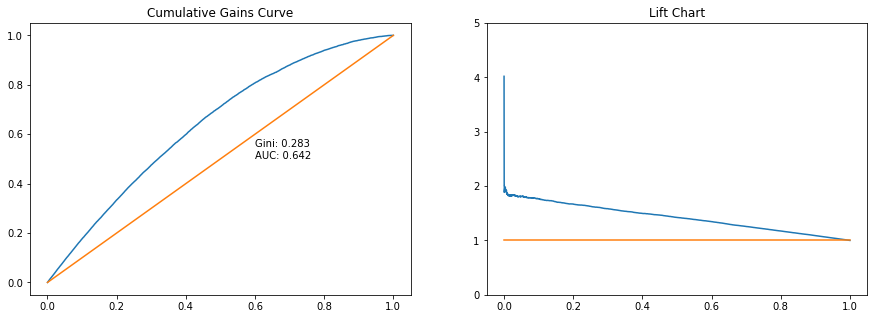

In [6]:
testLiftLR = test.Response.to_frame()
testLiftLR['probsLR'] = clf_l1_LR.predict_proba(X_test_scaled)[:,1]
fig, axes = plt.subplots(1,2,figsize=(15,5))
tLLR = testLiftLR.sort_values('probsLR', ascending = False).reset_index().Response.cumsum().to_frame()
tLLR.index = (1.0*tLLR.index)/len(tLLR); tLLR.Response = tLLR.Response/tLLR.Response.max()

axes[0].plot(tLLR.index,tLLR.Response)
axes[0].plot(np.array([0,1]),np.array([0,1]))
axes[0].set_title('Cumulative Gains Curve')
axes[1].plot(tLLR.index, tLLR.Response/tLLR.index)
axes[1].plot(np.array([0,1]),np.array([1,1]))
axes[1].set_title('Lift Chart')
axes[1].set_ylim([0,5])

axes[0].text(.6,.5,'Gini: {0}\nAUC: {1}'.format(
        round(2*(tLLR.Response - tLLR.index).sum()/len(tLLR),3),
        round(tLLR.Response.sum()/len(tLLR),3)))

### Gradient Boosting Machine (GBM)

The second machine learning classifier we will consider is gradient boosted trees. Leo Breiman, a pioneer in tree-based machine learning at U.C. Berkeley, has called gradient boosting, and specifically AdaBoost, the 'best off-the-shelf classifier in the world'. In my experience, it can be quite hard to beat a well-tuned GBM and the spate of Kaggle competitions won by GBMs further attest to their power. If you are familiar with classical gradient descent algorithms in mathematical optimization theory, the intuition behind GBM will be familiar. The following is a brief introduction to the idea of gradient boosting.

Given $N$ observations $\{y_i,x_i\}_{i=1}^{N}$, a class of predictor functions $F$, and a loss function $L$, the objective is to 
solve $$\underset{f \in F}{argmin}\sum\limits_{i=1}^N L(y_i, f(x_i))$$

In the case of gradient boosting, attention is restricted to the class of functions $F$ which can be written as the finite sum of weak learners from a given set of weak learners, typically decision trees. Gradient boosting then attempts to solve this problem iteratively.
At iteration $k+1$ we have an approximate solution $f_k$
from the previous iteration and we look to find a function $\eta_{k+1}$ such that the new approximate solution is
$f_{k+1}=f_k+\eta_{k+1}$. Let $\vec{f}_k$ be the $N$ x $1$ vector defined by $\vec{f}_{k,i} = f_k(x_i)$ and
let $\vec{\eta}$ also be an $N$ x $1$ vector. The derivative of the expression
$$\sum\limits_{i=1}^N L(y_i, \vec{f}_{k,i} + \vec{\eta}_{i})$$ with respect to $\vec{\eta}$, evaluated at
$\vec{\eta} = \vec{0}$, is an $N$ x $1$ vector, $\vec{\epsilon_{k+1}}$,
with $i^{th}$ element equal to $L_2(y_i, \vec{f}_{k,i})$. Regarding the objective function as a function of $\vec{\eta}$,
the direction of steepest descent is $-\vec{\epsilon_{k+1}}$, i.e. the negative of the gradient.
Gradient boosting takes $-\vec{\epsilon_{k+1}}$ as the target and fits a weak learner to it using $\vec{x}$ as predictors.
Calling this weak learner $\eta_{k+1}$, we set $f_{k+1} = f_k + \gamma\eta_{k+1}$, where $\gamma \in (0,1]$ is the learning rate.
We then continue to the next iteration. After $K$ iterations, the process is stopped,
yielding a final gradient boosting estimator $f_K$.

Fitting a GBM classifier in python requires only a few lines of code. Practitioners often use a procedure called cross validation to choose optimal values of the tuning parameters: the number of weak learners, the learning rate and, in the case of trees, the depth of the trees. To keep this example simple, we will skip tuning and just use 'reasonable' (read arbitrary) values for these parameters.

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1,
    max_depth=1, random_state=0, subsample = 0.75).fit(X_train_scaled.values, Y_train.values)

The plot below shows the improvement in fit of the GBM, as measured by deviance reduction on both the train and test sets, across successive boosting iterations. Notice that the deviance on the train set decreases significantly more than the deviance on the test set - this is a result of the GBM's tendency to overfit the training data.

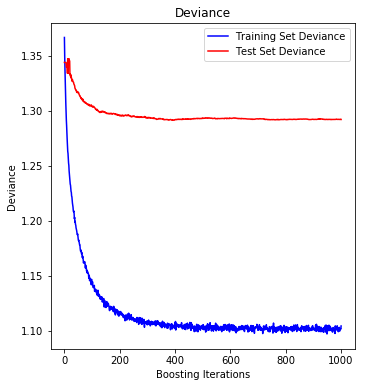

In [8]:
# compute test set deviance
test_score = np.zeros((clf.n_estimators,), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test_scaled.values)):
    test_score[i] = clf.loss_(Y_test.values, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(clf.n_estimators) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(clf.n_estimators) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='best')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

Again I plot the Cumulative Gains Curve and Lift Chart. The final plot shows the relative importance of the features in the GBM. For a given decision tree, the relative importance of the features is calculated as the number of samples split by each feature normalized to sum to one. The relative importance of the features in the GBM is the average of the relative importances of the features across the trees that comprise the GBM.

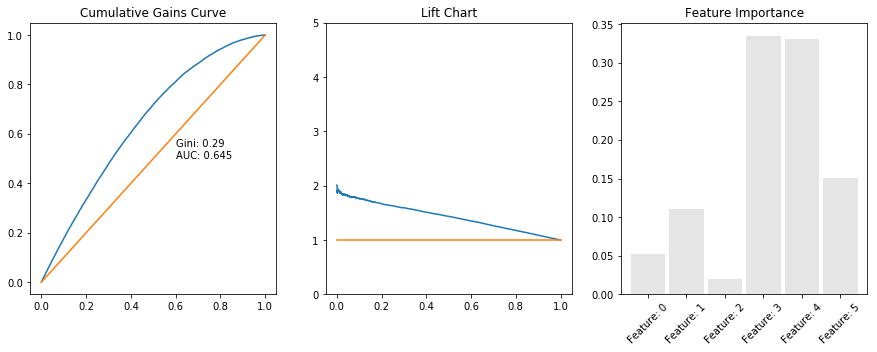

In [9]:
testLiftGBC = test.copy()
testLiftGBC['probsGBC'] = clf.predict_proba(X_test_scaled.values)[:,1]
fig, axes = plt.subplots(1,3,figsize=(15,5))
tLGBC = testLiftGBC.sort_values('probsGBC', ascending = False).reset_index().Response.cumsum().to_frame()
tLGBC.index = (1.0*tLGBC.index)/len(tLGBC); tLGBC.Response = tLGBC.Response/tLGBC.Response.max()
#tLGBC.plot(ax=axes[0])
axes[0].plot(tLGBC.index,tLGBC.Response)
axes[0].plot(np.array([0,1]),np.array([0,1]))
axes[0].set_title('Cumulative Gains Curve')
axes[1].plot(tLGBC.index, tLGBC.Response/tLGBC.index)
axes[1].plot(np.array([0,1]),np.array([1,1]))
axes[1].set_title('Lift Chart')
axes[1].set_ylim([0,5])
FeatureImportance = pd.DataFrame({'Feature':[i.split(' Level')[0] for i in X_train.columns.tolist()],
                                 'Importance':clf.feature_importances_}).groupby('Feature').sum()
FeatureImportance.plot(kind='bar', ax = axes[2], color='grey', alpha = 0.2,
                       legend = False, edgecolor = 'grey', lw = '0', width = 0.9)
axes[2].set_xlabel(''); axes[2].set_title('Feature Importance')
for tk in axes[2].get_xticklabels():
    tk.set_rotation(45)
axes[0].text(.6,.5,'Gini: {0}\nAUC: {1}'.format(
        round(2*(tLGBC.Response - tLGBC.index).sum()/len(tLGBC),3),
        round(tLGBC.Response.sum()/len(tLGBC),3)))

## Feed Forward Neural Network

The final set of machine learning models we will consider are artificial neural networks. First, we will consider fitting a fully connected feed forward neural network with an input layer, two hidden layers and an output layer:

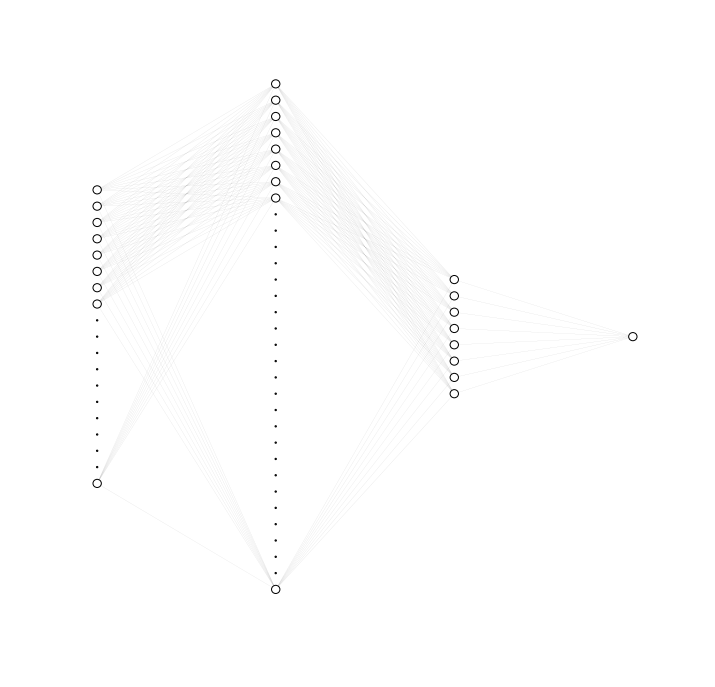

In [10]:
import draw_neural_net
reload(draw_neural_net)
from draw_neural_net import draw_neural_net
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [X_train_scaled.shape[1], 32, 8, 1])
fig.show()

In [4]:
# Using keras with TensorFlow backend
import keras
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [5]:
inputs = Input(shape = (X_train_scaled.shape[1],))
Layer1 = Dense(32,activation = 'sigmoid')(inputs)
Layer2 = Dense(8, activation = 'sigmoid')(Layer1)
out = Dense(1, activation = 'sigmoid')(Layer2)
model = Model(inputs, out)
model.compile(loss='binary_crossentropy',optimizer='adam')

model.fit(X_train_scaled.values,Y_train.values,
          epochs=200, batch_size=1000, verbose=0)

Once again I plot the Cumulative Gains Curve and the Lift Chart:

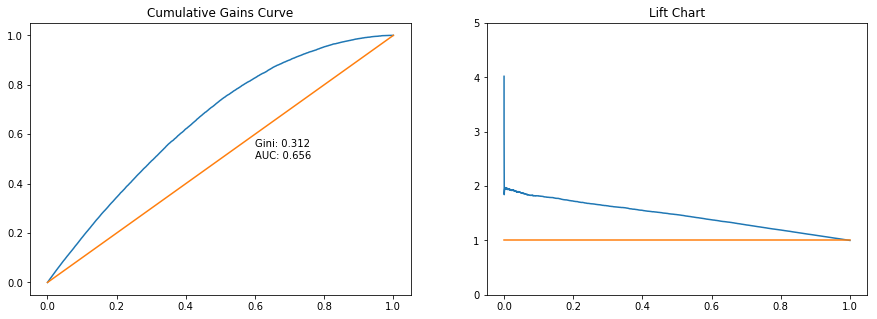

In [6]:
testLiftFFN = test.Response.to_frame()
testLiftFFN['probsFFN'] = model.predict(X_test_scaled.values)
fig, axes = plt.subplots(1,2,figsize=(15,5))
tLFFN = testLiftFFN.sort_values('probsFFN', ascending = False).reset_index().Response.cumsum().to_frame()
tLFFN.index = (1.0*tLFFN.index)/len(tLFFN); tLFFN.Response = tLFFN.Response/tLFFN.Response.max()

axes[0].plot(tLFFN.index,tLFFN.Response)
axes[0].plot(np.array([0,1]),np.array([0,1]))
axes[0].set_title('Cumulative Gains Curve')
axes[1].plot(tLFFN.index, tLFFN.Response/tLFFN.index)
axes[1].plot(np.array([0,1]),np.array([1,1]))
axes[1].set_title('Lift Chart')
axes[1].set_ylim([0,5])

axes[0].text(.6,.5,'Gini: {0}\nAUC: {1}'.format(
        round(2*(tLFFN.Response - tLFFN.index).sum()/len(tLFFN),3),
        round(tLFFN.Response.sum()/len(tLFFN),3)))

In [29]:
from ipywidgets import widgets
from IPython.display import display
text = widgets.Text()
display(text)